## NLP & Binary Classification: Yelp Business Rating Prediction
https://www.kaggle.com/c/yelp-recsys-2013

** Dataset Information: **

The data is a detailed dump of Yelp reviews, businesses, users, and checkins for the Phoenix, AZ metropolitan area.

** Attribute Information: (9 features and 1 class)**

- business_id
- date
- review_id
- stars
- text
- type
- user_id
- cool
- useful
- funny

** Objective of this project **

predict star ratings (1 or 5) based on reviews (text)

# Data

In [4]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

In [5]:
# Load Data
df = pd.read_csv('yelp.csv')
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


In [4]:
df.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


# Exploratory Data Analysis

In [10]:
df['text length'] = df['text'].apply(len)
df.head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889


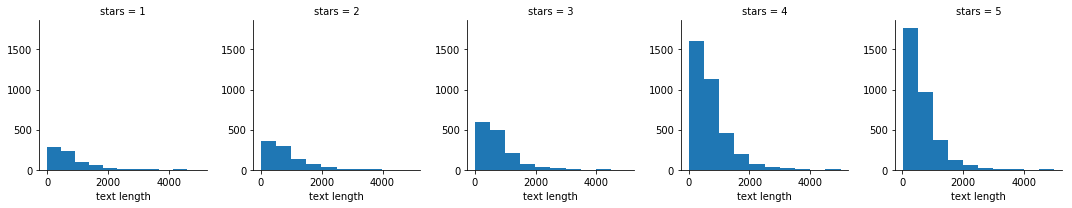

In [15]:
g = sns.FacetGrid(df,col='stars')
g.map(plt.hist,'text length')

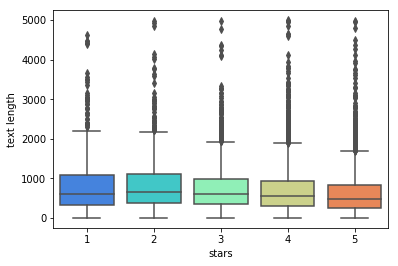

In [16]:
sns.boxplot(x='stars',y='text length',data=df,palette='rainbow')

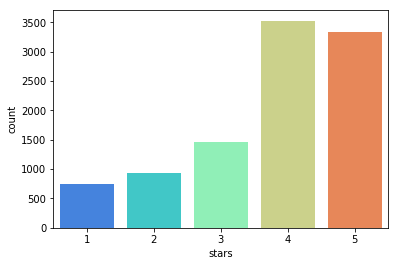

In [18]:
sns.countplot(x='stars',data=df,palette='rainbow') #imbalanced class--> stratify

In [19]:
stars = df.groupby('stars').mean()
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [20]:
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


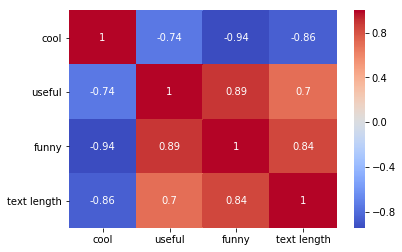

In [21]:
sns.heatmap(stars.corr(),cmap='coolwarm',annot=True)

# Data preprocessing

** Split Features & Class **

In [6]:
# only 1 and 5 stars (binary problem)
X = df[(df.stars==1) | (df.stars==5)]['text']
y = df[(df.stars==1) | (df.stars==5)]['stars']
print(X.shape,y.shape)

(4086,) (4086,)


** Split Train Test Sets **

In [7]:
seed = 101 #random seed for reproducibility
np.random.seed(seed)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y,random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3268,) (818,) (3268,) (818,)


In [9]:
np.unique(y_train,return_counts=True) #similar ratio to original class

(array([1, 5], dtype=int64), array([ 599, 2669], dtype=int64))

# 1. Bag-of-words Model

### Model Train

In [30]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
import string

# remove punctuation & stopwords
def text_process(mess):
    # remove punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    # join agint to string
    nopunc = ''.join(nopunc) 
    # remove stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

# create a data pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)), #tokenize
    ('classifier', MultinomialNB()),  #Naive Bayes classifier
])

# train model
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001A525F509D8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...None, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

Accuracy: 98.3%


             precision    recall  f1-score   support

          1       0.99      0.92      0.95       599
          5       0.98      1.00      0.99      2669

avg / total       0.98      0.98      0.98      3268



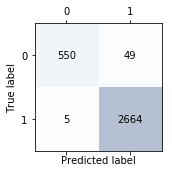

In [31]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

#accuracy score
y_pred_train = pipeline.predict(X_train)
print('Accuracy: {:0.1f}%'.format(accuracy_score(y_train,y_pred_train)*100))

#classification report
print('\n')
print(classification_report(y_train, y_pred_train))

#confusion matrix
confmat = confusion_matrix(y_train, y_pred_train)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

### Model Evaluation with Test set

Accuracy: 91.9%


             precision    recall  f1-score   support

          1       0.90      0.63      0.74       150
          5       0.92      0.98      0.95       668

avg / total       0.92      0.92      0.91       818



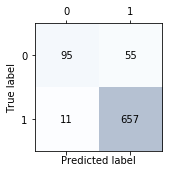

In [32]:
# predict class with test set (new, unseen)
y_pred_test = pipeline.predict(X_test)
print('Accuracy: {:0.1f}%'.format(accuracy_score(y_test,y_pred_test)*100))

#classification report
print('\n')
print(classification_report(y_test, y_pred_test))

#confusion matrix
confmat = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

# 2. TF-IDF

### Model train

In [33]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
import string

# remove punctuation & stopwords
def text_process(mess):
    # remove punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    # join agint to string
    nopunc = ''.join(nopunc) 
    # remove stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

# create a data pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)), #tokenize
    ('tfidf', TfidfTransformer()),  #TF-IDF
    ('classifier', MultinomialNB()),  #Naive Bayes classifier
])

# train model
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001A5261F5A60>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

Accuracy: 81.8%


             precision    recall  f1-score   support

          1       1.00      0.01      0.02       599
          5       0.82      1.00      0.90      2669

avg / total       0.85      0.82      0.74      3268



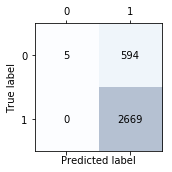

In [28]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

#accuracy score
y_pred_train = pipeline.predict(X_train)
print('Accuracy: {:0.1f}%'.format(accuracy_score(y_train,y_pred_train)*100))

#classification report
print('\n')
print(classification_report(y_train, y_pred_train))

#confusion matrix
confmat = confusion_matrix(y_train, y_pred_train)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

### Model Evaluation with Test set

In [34]:
import warnings
warnings.filterwarnings("ignore")

Accuracy: 81.7%


             precision    recall  f1-score   support

          1       0.00      0.00      0.00       150
          5       0.82      1.00      0.90       668

avg / total       0.67      0.82      0.73       818



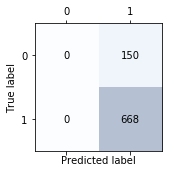

In [35]:
# predict class with test set (new, unseen)
y_pred_test = pipeline.predict(X_test)
print('Accuracy: {:0.1f}%'.format(accuracy_score(y_test,y_pred_test)*100))

#classification report
print('\n')
print(classification_report(y_test, y_pred_test))

#confusion matrix
confmat = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()